### Probly - Evidential Regression Tutorial

The `probly.transformation.evidential.regression` module transforms standard regression models into uncertainty-aware ones.

Simplified: In standard regression, a neural network predicts **a single number**, like a temperature, price, or position. But in real life, predictions are often uncertain. Sometimes the model *doesn't know* because of noise or missing data. 

This is where evidential regression comes into play. Instead of giving just one prediction like a normal regression model,  Evidential Regression can also tell us **how certain** the model is about its prediction.  
This comes in handy when your data is noisy or incomplete.

In this tutorial, we will:
1. Build a small neural network for a simple regression task  
2. Turn it into an **Evidential Model** that predicts both a value *and* its uncertainty  
3. Generate and visualize some test data  
4. See how uncertainty looks in the model’s predictions  
5. Try it yourself with a small exercise at the end  

## 1. Setup

Let’s import the libraries we need:
- **torch** → for building neural networks  
- **matplotlib** → for plotting  
- **probly.evidential_regression** → to turn a normal model into an uncertainty-aware one

In [8]:
import matplotlib.pyplot as plt
import torch
from torch import nn

from probly.transformation.evidential.regression.common import evidential_regression

## 2. Build a simple regression model

Here we make a small neural network that takes one input and predicts one output.  
Right now, it’s just a normal regression model — no uncertainty yet.

In [9]:
model = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
)

print("Base model:")
print(model)

Base model:
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=1, bias=True)
)


## 3. Turn it into an Evidential Model

With one line of code, Probly replaces the last layer with a special **Evidential layer** that predicts 4 values instead of 1.  
These values represent both the prediction and its uncertainty.

In [10]:
evidential_model = evidential_regression(model)

print("\nEvidential model:")
print(evidential_model)


Evidential model:
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): NormalInverseGammaLinear()
)


## 4. Synthetic Data

We’ll generate a simple sine curve with a little noise so the model has something to learn.

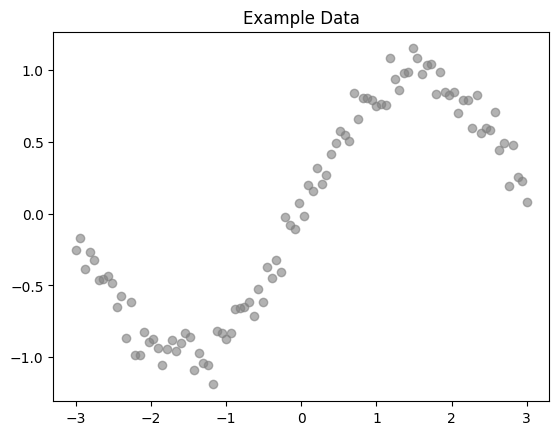

In [11]:
x = torch.linspace(-3, 3, 100).unsqueeze(-1)
y = torch.sin(x) + 0.1 * torch.randn_like(x)

plt.scatter(x, y, color="gray", alpha=0.6)
plt.title("Example Data")
plt.show()

## 5. Run the model

Let’s see what the model gives us when we pass the input `x`.  
It should output multiple values, not just one. 

In [12]:
with torch.no_grad():
    out = evidential_model(x)

print("Model output:")
print(out)

Model output:
{'gamma': tensor([[0.0702],
        [0.0725],
        [0.0748],
        [0.0772],
        [0.0795],
        [0.0818],
        [0.0842],
        [0.0865],
        [0.0888],
        [0.0912],
        [0.0935],
        [0.0958],
        [0.0981],
        [0.1005],
        [0.1028],
        [0.1051],
        [0.1075],
        [0.1098],
        [0.1121],
        [0.1145],
        [0.1168],
        [0.1191],
        [0.1215],
        [0.1226],
        [0.1221],
        [0.1202],
        [0.1175],
        [0.1147],
        [0.1120],
        [0.1093],
        [0.1066],
        [0.1038],
        [0.1011],
        [0.0984],
        [0.0971],
        [0.0970],
        [0.0970],
        [0.0970],
        [0.0970],
        [0.0970],
        [0.0970],
        [0.0969],
        [0.1021],
        [0.1115],
        [0.1217],
        [0.1320],
        [0.1407],
        [0.1474],
        [0.1541],
        [0.1608],
        [0.1688],
        [0.1792],
        [0.1861],
        [0.1913],
    

## 6. Check the uncertainty

Some models return 4 outputs:  
- `mu` (mean) → main prediction  
- `v`, `alpha`, `beta` → uncertainty parameters

We can use these to estimate how uncertain the model is.

In [ ]:
from __future__ import annotations  # noqa: F404

from typing import TYPE_CHECKING

import matplotlib.pyplot as plt
import torch
from torch import Tensor

from probly.quantification.regression import (
    expected_conditional_variance,
    total_variance,
    variance_conditional_expectation,
)

if TYPE_CHECKING:
    import numpy as np


def nig_predictive_variance(
    mu: Tensor,  # noqa: ARG001
    v: Tensor,
    alpha: Tensor,
    beta: Tensor,
) -> Tensor:
    """Compute predictive variance of Evidential Regression using a
    Normal-Inverse-Gamma likelihood.
    """  # noqa: D205
    return beta / (v * (alpha - 1).clamp(min=1e-3))


def build_gaussian_samples(
    mu: Tensor,
    var: Tensor,
    n_samples: int = 50,
) -> tuple[Tensor, Tensor]:
    """Build Gaussian samples (mu_samples, var_samples).

    - mu_samples: shape (n_instances, n_samples)
    - var_samples: shape (n_instances, n_samples)
    """
    n_instances: int = mu.shape[0]

    # Sample from Normal(mu, sqrt(var))
    eps: Tensor = torch.randn(n_instances, n_samples, device=mu.device)
    mu_samples: Tensor = mu.unsqueeze(1) + eps * var.sqrt().unsqueeze(1)

    # Variance stays the same for all samples
    var_samples: Tensor = var.unsqueeze(1).repeat(1, n_samples)

    return mu_samples, var_samples


def gaussian_samples_to_numpy(
    mu_samples: Tensor,
    var_samples: Tensor,
) -> np.ndarray:
    """Convert PyTorch (mu, var) samples to NumPy array with shape.

        (n_instances, n_samples, 2)

    with last dimension representing [mu, sigma^2].
    """
    probs: Tensor = torch.stack([mu_samples, var_samples], dim=-1)
    return probs.cpu().numpy()


def plot_evidential_regression_uncertainty(
    x: Tensor,
    y: Tensor,
    out: tuple[Tensor, Tensor, Tensor, Tensor],
    n_samples: int = 50,
) -> None:
    """Visualize evidential regression mean + uncertainty using Problys quantification APIs.

    Args:
        x: Input values used for plotting (n_instances, 1 or n_instances)
        y: Target values (n_instances,)
        out: Tuple (mu, v, alpha, beta) from evidential regression predictor
        n_samples: Number of Gaussian samples to draw per instance
    """
    mu, v, alpha, beta = out

    # 1. Predictive variance from NIG
    var: Tensor = nig_predictive_variance(mu, v, alpha, beta)

    # 2. Build Gaussian samples
    mu_s, var_s = build_gaussian_samples(mu, var, n_samples=n_samples)

    # 3. Convert to numpy for Quantification API
    probs_np: np.ndarray = gaussian_samples_to_numpy(mu_s, var_s)

    # 4. Compute uncertainty measures
    total_unc: np.ndarray = total_variance(probs_np)
    aleatoric_unc: np.ndarray = expected_conditional_variance(probs_np)  # noqa: F841
    epistemic_unc: np.ndarray = variance_conditional_expectation(probs_np)  # noqa: F841

    # 5. Plot results
    plt.plot(x, mu, color="blue", label="Predicted Mean")

    # Total uncertainty → shading band
    plt.fill_between(
        x.squeeze(),
        (mu - torch.from_numpy(total_unc)).squeeze(),
        (mu + torch.from_numpy(total_unc)).squeeze(),
        color="blue",
        alpha=0.2,
        label="Total Uncertainty",
    )

    plt.scatter(x, y, color="gray", alpha=0.5, label="Data")
    plt.title("Evidential Regression (Probly Quantification)")
    plt.legend()
    plt.show()

## 7. Exercise 

Build a small model, make it evidential, and confirm that the last layer was replaced automatically.

### Task:
1. Create a simple model with a few `Linear` and `ReLU` layers  
2. Apply `evidential_regression()` to it  
3. Print the model and check what the **last layer** became  

In [18]:
# ruff: noqa: TD003

# TODO(@todo): 1. Build a simple model (hint: use nn.Sequential)
student_model = None  # your model here

# TODO(@todo): 2. Apply evidential regression
student_evidential = None  # call evidential_regression()

# TODO(@todo): 3. Print to inspect the transformation
print("Transformed model:")
print(student_evidential)

Transformed model:
None


## 8. Summary

You just learned how to:
- Build a simple regression model in PyTorch  
- Transform it into an uncertainty-aware version using **Probly**  
- Visualize what “uncertainty” looks like  

Evidential Regression lets a model say *“I’m not sure here”* —  
which is extremely valuable in real-world applications like self-driving, healthcare or finance.